In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np 
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import itertools
import warnings
import scipy.signal as sp
import math
from statsmodels.tsa.stattools import acf, pacf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import datetime

C:\Users\trevo\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [130]:
#importing zonal data from 2015 to illustrate dominance of Toronto Zone
zone2015 = pd.read_csv("ZonalDemands_2015.csv", parse_dates=["Date"],index_col="Date")


#importing zonal data from 2015-2017, only taking total consumption
demand2013 = pd.read_csv("ZonalDemands_2013.csv", usecols = [0,1,2])
demand2014 = pd.read_csv("ZonalDemands_2014.csv", usecols = [0,1,2])
demand2015 = pd.read_csv("ZonalDemands_2015.csv", usecols = [0,1,2])
demand2016 = pd.read_csv("ZonalDemands_2016.csv", usecols = [0,1,2])

dTot_test = pd.read_csv("ZonalDemands_2017.csv", usecols = [0,1,2])



#merge all demand data
dTot = pd.concat([demand2013,demand2014,demand2015,demand2016])
#cleaning and changing to pandas datetime??




In [131]:
#importanting weather data
temp = pd.read_csv("temperature.csv", usecols = [0,26], parse_dates=["datetime"], index_col="datetime")
#convert to degrees celsius
temp = temp - 273.15

In [132]:
dTot['Date_Hour'] = pd.to_datetime(dTot.Date) + pd.to_timedelta(dTot.Hour, unit='h')

dTot = dTot.drop(['Date','Hour'],axis = 1)

dTot = dTot.set_index('Date_Hour')

dTot_test['Date_Hour'] = pd.to_datetime(dTot_test.Date) + pd.to_timedelta(dTot_test.Hour, unit='h')

dTot_test = dTot_test.drop(['Date','Hour'],axis = 1)

dTot_test = dTot_test.set_index('Date_Hour')


In [133]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

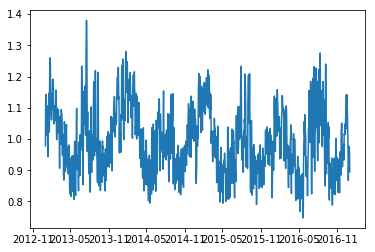

In [134]:
dTot = dTot.resample('D').mean()

dTot_log = (dTot.Total/dTot.Total.mean())
plt.plot(dTot_log)

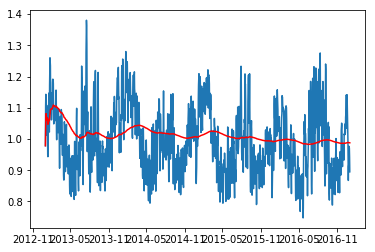

In [139]:
expwighted_avg = pd.ewma(dTot_log, halflife=365)
plt.plot(dTot_log)
plt.plot(expwighted_avg, color='red')

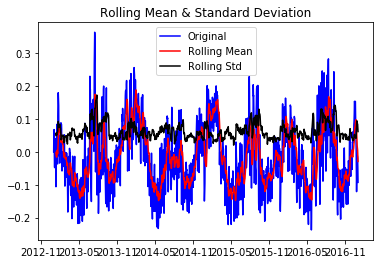

Results of Dickey-Fuller Test:
Test Statistic                   -4.133463
p-value                           0.000852
#Lags Used                       21.000000
Number of Observations Used    1440.000000
Critical Value (1%)              -3.434899
Critical Value (5%)              -2.863549
Critical Value (10%)             -2.567840
dtype: float64


In [140]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(dTot_log)

#trend = decomposition.trend
#seasonal = decomposition.seasonal
#residual = decomposition.resid

#dTot_log_decompose = residual
#dTot_log_decompose.dropna(inplace=True)
#test_stationarity(dTot_log_decompose.Total)

dTot_log_ewma_diff = dTot_log - expwighted_avg
test_stationarity(dTot_log_ewma_diff)


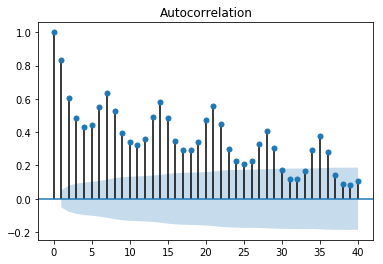

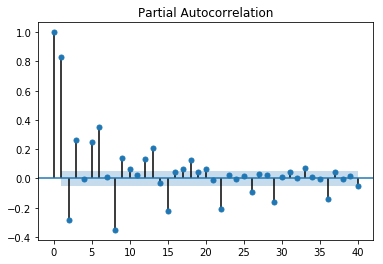

In [141]:
#print(dTot_log_decompose)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()

fig = sm.graphics.tsa.plot_acf(dTot_log_ewma_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot()
fig = sm.graphics.tsa.plot_pacf(dTot_log_ewma_diff, lags=40, ax=ax2)

In [183]:
#find optimal hyperparameters
p = d = q = range(0,1)

#pdq  = list(itertools.product(p,d,q))

#print('ARIMA{}-AIC{}'.format(pdq[i],results_AR.aic))

min_aic = 10000000
#min_aic_params = pdq[0]

#warnings.filterwarnings("ignore")

for i in range(0,len(pdq)+1):
        try:
            model = ARIMA(dTot_log_ewma_diff, order=pdq[i])  
            results_AR = model.fit(disp=-1)  
            
            if abs(results_AR.aic) < min_aic:
                min_aic = abs(results_AR.aic)
                min_aic_param = 'ARIMA{}-AIC{}'.format(pdq[i],abs(results_AR.aic))
                
            print('ARIMA{}-AIC{}'.format(pdq[i],results_AR.aic))
            
        except:
            continue

print(min_aic)
print(min_aic_params)

ARIMA(0, 0, 0)-AIC-2555.4817742166406
ARIMA(0, 0, 1)-AIC-3865.9844417327377
ARIMA(0, 1, 0)-AIC-4152.108770434422
ARIMA(0, 1, 1)-AIC-4262.3193534880265
ARIMA(0, 1, 2)-AIC-4460.833317401981
ARIMA(0, 1, 3)-AIC-4575.626911484236
ARIMA(0, 1, 4)-AIC-4577.1394868658845
ARIMA(0, 1, 7)-AIC-4755.274863494087
ARIMA(0, 1, 8)-AIC-4759.133100253759
ARIMA(0, 1, 9)-AIC-4804.9602738688845
ARIMA(0, 1, 10)-AIC-4807.549207095595
ARIMA(0, 2, 0)-AIC-3419.230510287868
ARIMA(0, 2, 1)-AIC-4138.979165486302
ARIMA(0, 2, 2)-AIC-4249.753878401309
ARIMA(0, 2, 3)-AIC-4442.669886304124
ARIMA(1, 0, 0)-AIC-4280.211515216649
ARIMA(1, 0, 1)-AIC-4484.530451679636
ARIMA(1, 0, 2)-AIC-4494.175305006994
ARIMA(1, 0, 3)-AIC-4590.922598749704
ARIMA(1, 0, 4)-AIC-4591.845328111868
ARIMA(1, 0, 5)-AIC-4597.690079860969
ARIMA(1, 0, 6)-AIC-4619.467092499727
ARIMA(1, 0, 7)-AIC-4773.814760558601
ARIMA(1, 0, 8)-AIC-4772.295984183694
ARIMA(1, 0, 9)-AIC-4820.448594603974
ARIMA(1, 0, 10)-AIC-4822.507174922309
ARIMA(1, 1, 0)-AIC-4195.8775324

ARIMA(9, 0, 3)-AIC-5094.344153929017
ARIMA(9, 0, 4)-AIC-5277.03701470706
ARIMA(9, 0, 5)-AIC-5298.605376348795
ARIMA(9, 0, 6)-AIC-5321.8845152577405
ARIMA(9, 0, 7)-AIC-5408.362309524197
ARIMA(9, 0, 8)-AIC-5420.057795956803
ARIMA(9, 0, 9)-AIC-5430.663167761483
ARIMA(9, 0, 10)-AIC-5428.062414739453
ARIMA(9, 1, 0)-AIC-4975.478001253279
ARIMA(9, 1, 1)-AIC-5014.059961504199
ARIMA(9, 1, 2)-AIC-5012.231365537638
ARIMA(9, 1, 3)-AIC-5012.1215678596855
ARIMA(9, 1, 4)-AIC-5224.211838737652
ARIMA(9, 1, 5)-AIC-5237.655204960662
ARIMA(9, 1, 6)-AIC-5299.179142641331
ARIMA(9, 1, 8)-AIC-5410.559650053821
ARIMA(9, 1, 9)-AIC-5408.0030119463245
ARIMA(9, 1, 10)-AIC-5413.1313149920625
ARIMA(9, 2, 0)-AIC-4726.658181553854
ARIMA(9, 2, 1)-AIC-4948.93439294087
ARIMA(9, 2, 2)-AIC-4946.987562802546
ARIMA(9, 2, 3)-AIC-4998.277052022462
ARIMA(9, 2, 4)-AIC-5040.623329259244
ARIMA(9, 2, 5)-AIC-4994.278063191048
ARIMA(10, 0, 0)-AIC-5008.687066168323
ARIMA(10, 0, 1)-AIC-5029.429160671573
ARIMA(10, 0, 2)-AIC-5138.2575526

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Total   No. Observations:                 1462
Model:                    ARMA(27, 0)   Log Likelihood                2664.567
Method:                       css-mle   S.D. of innovations              0.039
Date:                Wed, 14 Mar 2018   AIC                          -5271.134
Time:                        01:01:18   BIC                          -5117.794
Sample:                    01-01-2013   HQIC                         -5213.936
                         - 01-01-2017                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0144      0.016     -0.888      0.375      -0.046       0.017
ar.L1.Total      1.0586      0.026     40.462      0.000       1.007       1.110
ar.L2.Total     -0.3350      0.038     -8.820      0.000      -0.409      -0.261
ar.L3.Total      0.1209      0.039      3.114      0.002       0.045       0.197
ar.L4.Total     -0.0776      0.039     -1.990      0.047      -0.154      -0.001
ar.L5.Total      0.0181      0.039      0.463      0.643      -0.058       0.095
ar.L6.Total      0.0120      0.038      0.313      0.755      -0.063       0.087
ar.L7.Total      0.2572      0.038      6.770      0.000       0.183       0.332
ar.L8.Total     -0.2688      0.039     -6.970      0.000      -0.344      -0.193
ar.L9.Total      0.0869      0.039      2.218      0.027       0.010       0.164
ar.L10.Total     0.0538      0.039      1.369      0.171      -0.023       0.131
ar.L11.Total    -0.0967      0.039     -2.460      0.014      -0.174      -0.020
ar.L12.Total    -0.0403      0.039     -1.023      0.307      -0.117       0.037
ar.L13.Total     0.1479      0.039      3.782      0.000       0.071       0.224
ar.L14.Total     0.1413      0.039      3.608      0.000       0.065       0.218
ar.L15.Total    -0.1844      0.039     -4.713      0.000      -0.261      -0.108
ar.L16.Total     0.0156      0.039      0.396      0.692      -0.062       0.093
ar.L17.Total    -0.0463      0.039     -1.177      0.240      -0.123       0.031
ar.L18.Total     0.0576      0.039      1.465      0.143      -0.019       0.135
ar.L19.Total     0.0249      0.039      0.634      0.526      -0.052       0.102
ar.L20.Total    -0.0054      0.039     -0.139      0.890      -0.081       0.070
ar.L21.Total     0.2268      0.038      5.957      0.000       0.152       0.301
ar.L22.Total    -0.2451      0.039     -6.357      0.000      -0.321      -0.170
ar.L23.Total     0.0375      0.039      0.958      0.338      -0.039       0.114
ar.L24.Total    -0.0527      0.039     -1.348      0.178      -0.129       0.024
ar.L25.Total     0.1285      0.039      3.296      0.001       0.052       0.205
ar.L26.Total    -0.1262      0.038     -3.312      0.001      -0.201      -0.052
ar.L27.Total     0.0293      0.026      1.114      0.266      -0.022       0.081
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0564           -0.1485j            1.0667           -0.4778
AR.2            -1.0564           +0.1485j            1.0667            0.4778
AR.3            -0.9418           -0.4331j            1.0366           -0.4314
AR.4            -0.9418           +0.4331j            1.0366            0.4314
AR.5            -0.8673           -0.7299j            1.1336           -0.3887
AR.6            -0.

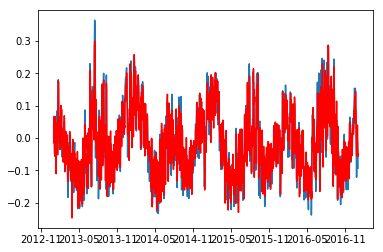

In [189]:
#make model plot transforms vs predicted tranforms
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(dTot_log_ewma_diff, order=(27, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(dTot_log_ewma_diff)
plt.plot(results_AR.fittedvalues, color='red')
#print(results_AR.fittedvalues.tail())
#print(dTot_log_decompose)
#print(sum((results_AR.fittedvalues-dTot_log_ewma_diff.Total)**2))
results_AR.summary()

In [190]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
#pred_2017_diff = results_AR.predict(start = '2017-02-28', end = '2017-12-31')
pred_2017_diff = pd.Series(results_AR.forecast(steps = 366)[0],copy = True)

#index = ['2017-02-28','2017-03-31','2017-04-30','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-30','2017-10-31','2017-11-30','2017-12-31'] 
#pred_2017_diff.index = pd.to_datetime(pred_2017_diff.index)

pred_2017_diff.index = dTot_test.resample('D').mean().index



print(pred_2017_diff)
print(predictions_ARIMA_diff)

Date_Hour
2017-01-01   -0.039467
2017-01-02   -0.018054
2017-01-03    0.002255
2017-01-04    0.014944
2017-01-05    0.007932
2017-01-06   -0.035781
2017-01-07   -0.067621
2017-01-08   -0.018363
2017-01-09   -0.008833
2017-01-10   -0.008568
2017-01-11   -0.011159
2017-01-12   -0.017706
2017-01-13   -0.067784
2017-01-14   -0.100363
2017-01-15   -0.057886
2017-01-16   -0.040089
2017-01-17   -0.016412
2017-01-18   -0.007748
2017-01-19   -0.009350
2017-01-20   -0.048644
2017-01-21   -0.069773
2017-01-22   -0.033654
2017-01-23   -0.017768
2017-01-24   -0.006059
2017-01-25   -0.001785
2017-01-26   -0.004677
2017-01-27   -0.042599
2017-01-28   -0.064048
2017-01-29   -0.033284
2017-01-30   -0.018600
                ...   
2017-12-03   -0.014731
2017-12-04   -0.014128
2017-12-05   -0.014174
2017-12-06   -0.014069
2017-12-07   -0.013999
2017-12-08   -0.014701
2017-12-09   -0.015233
2017-12-10   -0.014708
2017-12-11   -0.014152
2017-12-12   -0.014197
2017-12-13   -0.014103
2017-12-14   -0.014035
2

In [191]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff #.cumsum()
pred_2017_diff_cumsum = pred_2017_diff #.cumsum()
print(pred_2017_diff_cumsum.head())
print(predictions_ARIMA_diff_cumsum.head())

Date_Hour
2017-01-01   -0.039467
2017-01-02   -0.018054
2017-01-03    0.002255
2017-01-04    0.014944
2017-01-05    0.007932
Freq: D, dtype: float64
Date_Hour
2013-01-01   -0.014438
2013-01-02   -0.002436
2013-01-03    0.064269
2013-01-04    0.039277
2013-01-05   -0.004328
Freq: D, dtype: float64


In [192]:


predictions_ARIMA_log = pd.Series(expwighted_avg.iloc[0], index=dTot_log.index)
#print(predictions_ARIMA_log )
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#predictions_ARIMA_log.head()

pred_2017_log = dTot_log.iloc[0]
#print(predictions_ARIMA_log )
pred_2017_log = pred_2017_log + pred_2017_diff_cumsum
#predictions_ARIMA_log.head()


print(pred_2017_log.head())
print(predictions_ARIMA_log.tail())

Date_Hour
2017-01-01    0.939008
2017-01-02    0.960422
2017-01-03    0.980731
2017-01-04    0.993419
2017-01-05    0.986407
Freq: D, dtype: float64
Date_Hour
2016-12-28    0.934820
2016-12-29    1.018312
2016-12-30    0.962782
2016-12-31    0.921175
2017-01-01    0.929272
Freq: D, dtype: float64


903.7247649272465


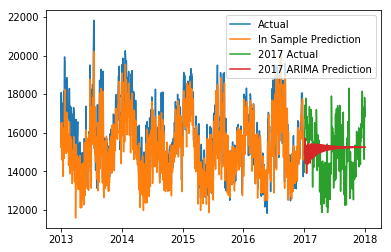

In [193]:
#multiply by mean
predictions_ARIMA = predictions_ARIMA_log*dTot.Total.mean()
pred_2017 = pred_2017_log*dTot.Total.mean()


start = '2013'
end = '2016'


plt.plot(dTot[start:end])
plt.plot(predictions_ARIMA[start:end])
plt.plot(dTot_test.resample('D').mean())
plt.plot(pred_2017)
plt.legend(['Actual','In Sample Prediction', '2017 Actual','2017 ARIMA Prediction'])

print(np.sqrt(sum((predictions_ARIMA[start:end]-dTot[start:end].Total)**2)/len(dTot.Total)))


